# Foundation Neural Operator learning of the Allen Cahn equation

In [1]:
# load libaries

%load_ext autoreload
%autoreload 2

# libaries
import torch
import sys
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.fft as fft
from torch.optim import Adam
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

env_path = "./"

# for use with colab gpu
if "google.colab" in sys.modules:  # Only true if running in Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    # set this folder as env
    env_path = "drive/My Drive/projects/aise_final_project/3_FNM_AC/"
    sys.path.append(env_path)

from allen_cahn_generation import *
from model import AllenCahnFNO
from training import train_model, test_model, AllenCahnDataset
from data_processing import load_npz_data

Mounted at /content/drive


In [24]:
# dictionary with first level keys IC and second level keys epsilon with torch data of shape (n_samples, time_points, n_points)
train_data_raw = load_npz_data(env_path + "data/training_data_standard.npz")


# split validation and test data
split_idx = len(train_data_raw[0.1]) // 5
val_data = {eps: val_data[:split_idx].clone().detach() for eps, val_data in train_data_raw.items()}
train_data = {eps: train_data[split_idx:].clone().detach() for eps, train_data in train_data_raw.items()}
# print(split_idx)
# val_data = {eps: torch.tensor(val_data)[:split_idx] for eps, val_data in train_data_raw.items()}

# dataset = AllenCahnDataset(data, epsilon_values=[0.1, 0.07], time_points=[0, 0.0025, 0.005, 0.0075, 0.01])
# dataset.__getitem__(0)
for k in train_data_raw.keys():
    print(k, train_data_raw[k].shape)

0.1 torch.Size([300, 5, 128])
0.07 torch.Size([300, 5, 128])
0.05 torch.Size([300, 5, 128])
0.02 torch.Size([300, 5, 128])


Training:   0%|          | 0/120 [00:00<?, ?it/s]

Curriculum update: now training on epsilon values [0.1]
Curriculum update: now training on epsilon values [0.1, 0.07]
Curriculum update: now training on epsilon values [0.1, 0.07, 0.05]
Curriculum update: now training on epsilon values [0.1, 0.07, 0.05, 0.02]


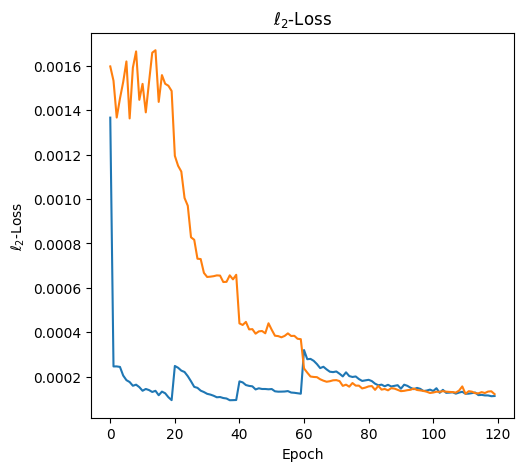

In [26]:
model = AllenCahnFNO(depth = 3)
epsilon_values = list(train_data.keys())
time_points = [0, 0.0025, 0.005, 0.0075, 0.01]
curriculum_steps = [
    (0, epsilon_values[:1]),
    (20, epsilon_values[:2]),
    (40, epsilon_values[:3]),
    (60, epsilon_values[:4])
]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trained_model = train_model(
    model,
    train_data,
    val_data,
    epsilon_values,
    time_points,
    batch_size=32,
    epochs=120,
    device=device,
    learning_rate=1e-3,
    weight_decay=0,#1e-7,
    epoch_patience = 10,
    curriculum_steps=curriculum_steps,
    beta_ = 0.05,
    gamma_ = 0.05
)




[(0, [0.1]), (20, [0.1, 0.07]), (40, [0.1, 0.07, 0.05]), (60, [0.1, 0.07, 0.05, 0.02])]


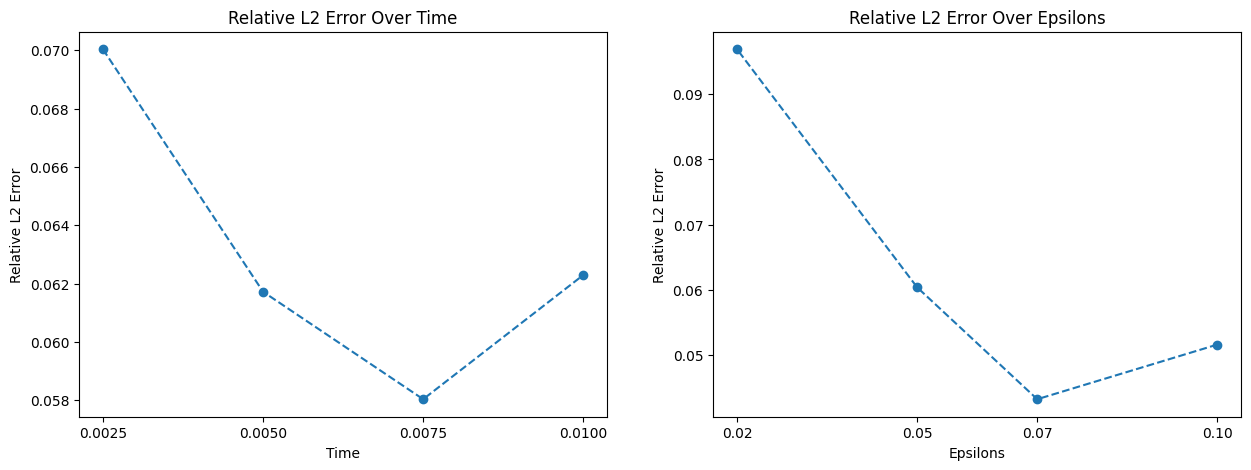

In [8]:

# TODO:
# TEST model
# Test dataloader behaves as expected
# add domain grid to channel in model if necessary (could also be done in loader)
# Implement custom loss function of L2 plug physical
# curriculum learning for IC?

# test_data = {eps: torch.tensor(val_data)[:100] for eps, val_data in train_data.items()}
test_data = load_npz_data(env_path + "data/test_data_standard.npz", for_exploration=False)

test_relative_l2_time, test_relative_l2_epsilon = test_model(trained_model, test_data, epsilon_values, time_points, show_plot=True)

torch.Size([960, 128, 1])
torch.Size([960, 128, 1])
torch.Size([960, 128, 4])
tensor([0.0200, 0.0500, 0.0700, 0.1000], device='cuda:0')
tensor([0.0025, 0.0050, 0.0075, 0.0100], device='cuda:0')


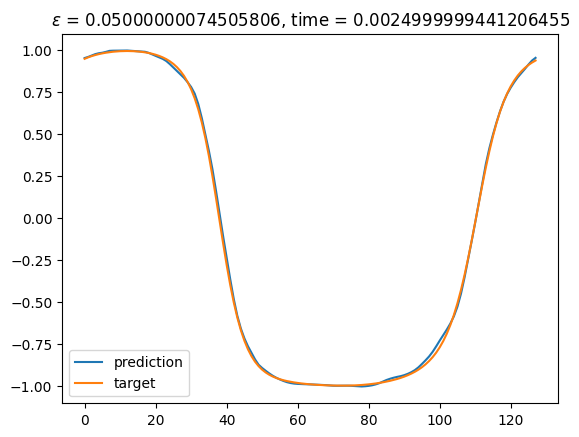

In [14]:
    idx = 500

    test_dataset = AllenCahnDataset(test_data, epsilon_values, time_points, simple_testing = True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    for i, batch in enumerate(test_loader):
      batch = {k: v.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")) for k, v in batch.items()}
      pred = model(batch['initial'], batch['epsilon'], batch['time'])
      print(pred.shape)
      print(batch['target'].shape)
      print(batch['initial'].shape)
      print(batch['epsilon'].unique())
      print(batch['time'].unique())
      plt.plot(pred[idx, :, :].cpu().detach().numpy(), label = "prediction")
      plt.plot(batch['target'][idx, :, :].cpu().detach().numpy(), label = "target")
      plt.legend()
      plt.title(f"$\epsilon$ = {batch['epsilon'][idx].item()}, time = {batch['time'][idx].item()}")
      plt.show()

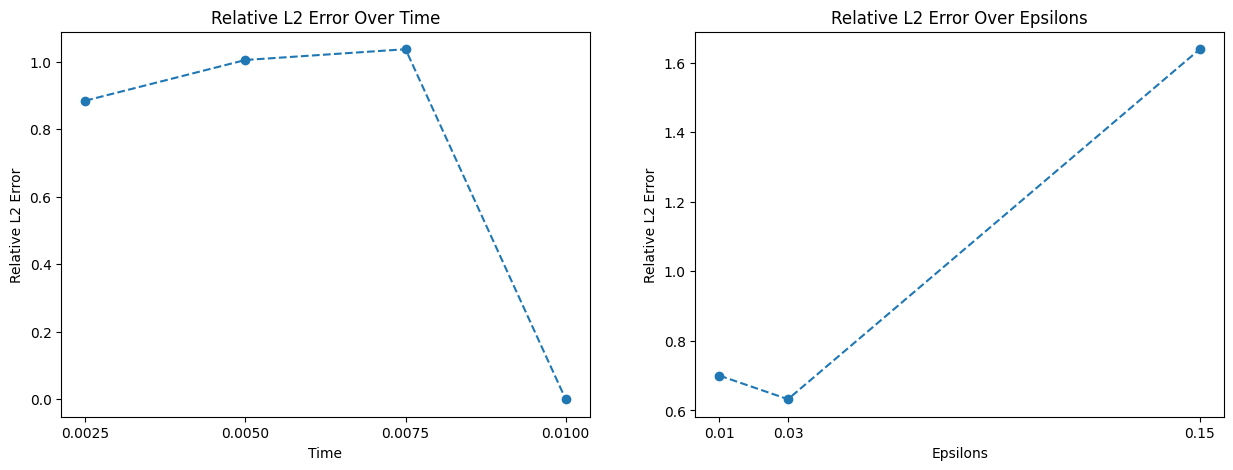

In [6]:
# test_data = {eps: torch.tensor(val_data)[:100] for eps, val_data in train_data.items()}
OOD_test_data = load_npz_data(env_path + "data/test_data_OOD.npz", for_exploration=True)


test_relative_l2_time, test_relative_l2_epsilon = test_model(model = trained_model, test_data = OOD_test_data["noise"], epsilon_values =  [0.01, 0.03, 0.15], time_points = time_points, show_plot=True)